### Imported the Following Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stop_words #Created a .py file with all stop_words I deemed not useful for my analysis
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/edwardmendoza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edwardmendoza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
bro_pill = pd.read_csv('../Datasets/bro_pill.csv')
male_mental_health = pd.read_csv('../Datasets/malementalhealth.csv')
mens_lib = pd.read_csv('../Datasets/Mens_Lib.csv')
ask_men = pd.read_csv('../Datasets/ask_men.csv')

In [6]:
combined_dfs = [mens_lib, male_mental_health, bro_pill, ask_men]

for df in combined_dfs:
    df.columns = ['title', 'selftext', 'subreddit', 'created_utc',
                  'author', 'num_comments', 'score', 'is_self', 'timestamp']

pd.concat(combined_dfs).reset_index(drop=True)

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Tuesday Check In: How's Everybody's Mental Hea...,Good morning everyone and welcome to our weekl...,MensLib,1614060020,MLModBot,111,21,True,2021-02-22
1,Masculinity and The Fear of Being Ordinary,"Do you feel a need to be ""superior"" or ""except...",MensLib,1614066596,spudmix,308,593,True,2021-02-22
2,Dating Resources?,[removed],MensLib,1614078549,GreatWyrm,4,2,True,2021-02-23
3,Vunrability,[removed],MensLib,1614083378,lizardwizthebiz,2,1,True,2021-02-23
4,Should men be able to walk away from having ki...,NaN,MensLib,1614089417,[deleted],6,1,True,2021-02-23
...,...,...,...,...,...,...,...,...,...
27239,"Guys who have never had a romantic, intimate a...",NaN,AskMen,1421017188,shamefulsomeone,0,1,True,2015-01-11
27240,How do you arrange dates?,I'm a 24yo bisexual guy. The continual annoyan...,AskMen,1421017774,[deleted],7,1,True,2015-01-11
27241,What are your favorite podcasts to listen to?,NaN,AskMen,1421020404,collegedropout1234,20,5,True,2015-01-11
27242,How would you respond to a hand written letter...,Is this really silly? Even if its simple and s...,AskMen,1421020444,illfindone,29,12,True,2015-01-11


In [7]:
mens_issues = pd.concat(combined_dfs).reset_index(drop=True)

In [8]:
mens_issues = mens_issues.drop(columns = ['created_utc', 'num_comments', 'score', 'is_self', 'timestamp'])

In [9]:
mens_issues.shape

(27244, 4)

#### Removing autobots from the dataset

In [10]:
mens_issues = mens_issues[(mens_issues['author'] != 'MLModBot')]
mens_issues = mens_issues[(mens_issues['author'] != 'Mr_Holmes')]
mens_issues = mens_issues[(mens_issues['author'] != 'Dewey_Darl')] 
mens_issues = mens_issues[(mens_issues['author'] != 'AutoModerator')]

### String Cleaning

Combining title and self text to ensure better text quality of the documents

Replacing `NaN` with an empty string so as concatenating the title and author will perform correctly.

In [13]:
mens_issues['selftext'].fillna(" ", inplace=True)

In [14]:
#function to remove string, specifically the [removed] string under the selftext column
def remove_string(df, column, string):
    df[column] = df[column].str.replace(string, '')

remove_string(mens_issues, 'selftext', '\[removed\]')

In [15]:
mens_issues['all_text'] = mens_issues['title'].str.cat(mens_issues['selftext'], sep=" ")

Will create a function to normalize and standardize the text within the subreddits.

In [16]:
#Credits to Gwen for function
def clean_strings(input_list, stopwords = []):
    import re # we'll use regex to strip urls
    output_list = [] # create output list
    stopwords = [word.lower() for word in stopwords] # ensure case insensitivity for stopwords
    for sentence in input_list:
        sentence = re.sub(r'^https?:\/\/.*[\r\n]*', '', str(sentence), flags=re.MULTILINE) # remove URLS per stackoverflow
        sentence = sentence.replace('\n',' ') # replace \n and \t with spaces as they represent breaks between words
        sentence = sentence.replace('\t',' ')
        sentence = ''.join([letter for letter in sentence if letter.isalpha() or letter == ' ']) #remove numbers and punctuation
        sentence = ' '.join([word for word in sentence.split() if len(word) < 25]) #exclude egregiously long words
        sentence = ' '.join([word.lower() for word in sentence.split() if word.lower() not in stopwords]) #coerce to lowercase while removing stopwords
        sentence = re.sub(r'\b\w{1,3}\b', '', str(sentence)) #removing words that are less than 3 letters long
        sentence = re.sub('[‘’“”…]', '', sentence)
        sentence = re.sub('\n', '', sentence)
        output_list.append(sentence) # add to the output list
    return output_list

In [17]:
#adding stopwords that I deem to be insufficient for my analysis
mens_issues['all_text'] = clean_strings(mens_issues['all_text'], stopwords = stop_words.stop_words)

In [18]:
#checking for nulls
mens_issues.isna().sum()

title        0
selftext     0
subreddit    0
author       0
all_text     0
dtype: int64

#### Removing Asian Characters from dataset

In [64]:
#code adapted by Lea Delacrus-Tordjeman
mens_issues.drop([i for i in mens_issues[mens_issues['all_text'].str.contains(r'[^\x00-\x7F]+') == True].index], inplace = True)

#### Lemmatize

In [19]:
#created function to lemmatize each word in all text
lemmatizer = WordNetLemmatizer()

def lemmatize_words(txt):
    """lemmatize words accepts a string"""
    words = txt.split()
    lem_words = ''
    for word in words:
        lem_words += (lemmatizer.lemmatize(word) + ' ')
    return lem_words

In [20]:
#saving this version for topic modeling in the future
#mens_issues.to_csv('./men_df_lem.csv', index=False)

#### Stemmatizer

In [21]:
#created function to stemmatize each word in all text
stemmatizer = PorterStemmer()

def stemmatize_words(txt):
    """stemmatize words accepts a string"""
    words = txt.split()
    stem_words = ''
    for word in words:
        stem_words += (stemmatizer.stem(word) + ' ')
    return stem_words

In [22]:
mens_issues['all_text'] = mens_issues['all_text'].apply(stemmatize_words)

In [23]:
#saving this version for topic modeling in the future
#mens_issues.to_csv('./men_df_stem.csv', index=False)

### Exploratory Data Analysis on Mens' Issues

In [24]:
#investigating the variety of string length
mens_issues['post_length'] = mens_issues['all_text'].str.len()

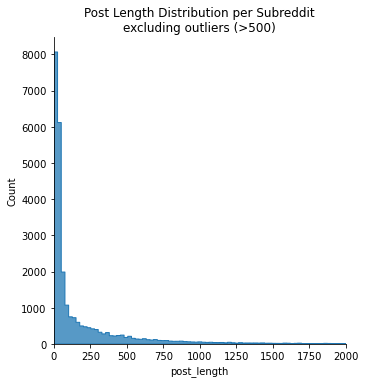

<Figure size 432x288 with 0 Axes>

In [25]:
g = sns.displot(mens_issues, x="post_length", legend=False, element="step", bins = 500)
plt.xlim(-1,2_000)
plt.title("Post Length Distribution per Subreddit\nexcluding outliers (>500)")
plt.show(g)
plt.tight_layout()

We see majority of the posts fall within the 0-100 words bucket, yet we can't ignore the posts that exceed the majority amount

In [26]:
cvec_eda = CountVectorizer(stop_words = 'english', max_features = 20_000)

X_eda = mens_issues['all_text']
X_eda = cvec_eda.fit_transform(X_eda)
X_eda_df = pd.DataFrame(X_eda.todense(), columns = cvec_eda.get_feature_names())

In [27]:
X_eda_df.shape

(26605, 20000)

In [28]:
X_eda_df.sum().sort_values(ascending = False).head(15)

want            10170
think            8075
friend           7464
women            5747
life             5496
work             5304
help             5072
girl             4768
feel             4740
good             4340
start            4311
need             4301
look             3958
relationship     3889
guy              3681
dtype: int64

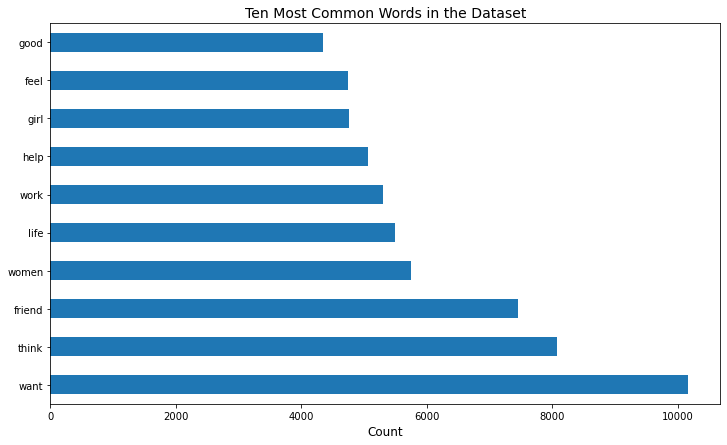

In [29]:
plt.figure(figsize=(12,7))
X_eda_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.title('Ten Most Common Words in the Dataset', size = 14)
plt.xlabel('Count', size = 12)
#plt.savefig('eda_words.png', dpi=300)
plt.show()

From bar graph above, I would like to see words where the length of the word is greater than 4 characters long, will create function in the next cell to display that

#### Exploring Most Common Words with Varying String Lengths

In [30]:
#updating function to filter out words that are less than 4 letters long
def clean_strings2(input_list, stopwords = []):
    import re # we'll use regex to strip urls
    output_list = [] # create output list
    stopwords = [word.lower() for word in stopwords] # ensure case insensitivity for stopwords
    for sentence in input_list:
        sentence = re.sub(r'^https?:\/\/.*[\r\n]*', '', str(sentence), flags=re.MULTILINE) # remove URLS per stackoverflow
        sentence = sentence.replace('\n',' ') # replace \n and \t with spaces as they represent breaks between words
        sentence = sentence.replace('\t',' ')
        sentence = ''.join([letter for letter in sentence if letter.isalpha() or letter == ' ']) #remove numbers and punctuation
        sentence = ' '.join([word for word in sentence.split() if len(word) > 4])
        sentence = ' '.join([word.lower() for word in sentence.split() if word.lower() not in stopwords]) #coerce to lowercase while removing stopwords
        sentence = re.sub(r'\b\w{1,3}\b', '', str(sentence)) #removing words that are less than 3 letters long
        sentence = re.sub('[‘’“”…]', '', sentence)
        sentence = re.sub('\n', '', sentence)
        output_list.append(sentence) # add to the output list
    return output_list

In [31]:
#adding stopwords that I deem to be insufficient for my analysis
mens_issues['all_text2'] = clean_strings2(mens_issues['all_text'], stopwords = stop_words.stop_words)

In [32]:
cvec_eda2 = CountVectorizer(stop_words = 'english', max_features = 10_000)

X_eda = mens_issues['all_text2']
X_eda = cvec_eda2.fit_transform(X_eda)
X_eda_df = pd.DataFrame(X_eda.todense(), columns = cvec_eda2.get_feature_names())

In [33]:
X_eda_df.sum().sort_values(ascending = False).head(15)

think           8075
friend          7464
women           5747
start           4311
relationship    3889
thought         3589
right           2688
better          2549
sexual          2441
masculin        2248
happen          2185
school          2185
problem         2162
point           2122
mental          2099
dtype: int64

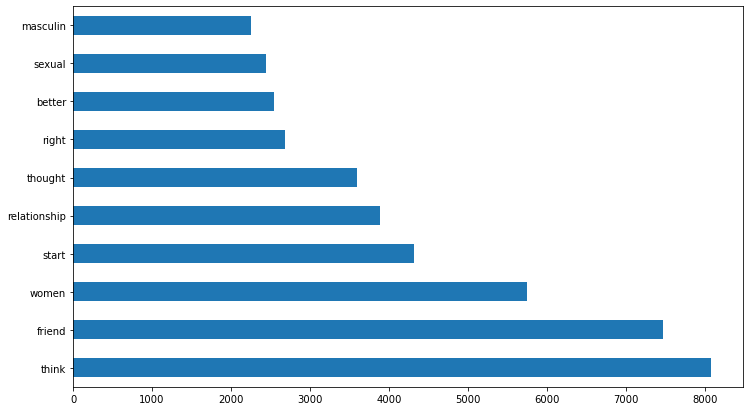

In [34]:
plt.figure(figsize=(12,7))
X_eda_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');
#plt.savefig('eda_words2.png', dpi=300)
plt.show()

#### Sentiment Analysis

In [35]:
#initializing corpus variable to list out the mens_issues['all_text'] column
corpus = list(mens_issues['all_text'])

In [36]:
sia = SentimentIntensityAnalyzer()

In [37]:
#Self-Checking polarity scores for the 10th document
sia.polarity_scores(corpus[9])

{'neg': 0.032, 'neu': 0.551, 'pos': 0.416, 'compound': 0.9894}

In [38]:
sentiment = []    

for el in corpus:
    scores = sia.polarity_scores(el)
    scores['alltext'] = el
    sentiment.append(scores)

df_sentiment = pd.DataFrame(sentiment)
df_sentiment.head(10)

,neg,neu,pos,compound,alltext
0,0.145,0.690,0.165,0.4767,masculin fear ordinari need superior except ch...
1,0.000,1.000,0.000,0.0000,date resourc
2,0.000,1.000,0.000,0.0000,vunrabl
3,0.000,1.000,0.000,0.0000,abl walk away have kid women abort
4,0.000,1.000,0.000,0.0000,mainstream
5,0.246,0.352,0.401,0.2960,think way talk popular discours harm convers b...
6,0.524,0.476,0.000,-0.2960,abl stop abort
7,0.000,1.000,0.000,0.0000,stereotyp
8,0.053,0.837,0.110,0.3612,anybodi check palgrav handbook male psycholog ...
9,0.032,0.551,0.416,0.9894,group better help woman wife boy girl licens p...


In [39]:
#initializing marker column 
df_sentiment['score'] = 0

<Figure size 720x504 with 0 Axes>

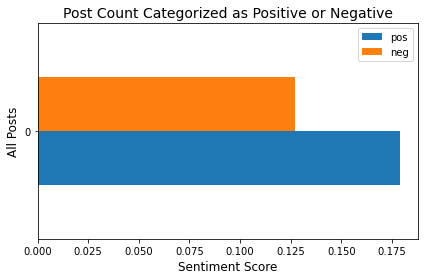

In [40]:
#plotting the average positive and negative scores for all posts
plt.figure(figsize=(10,7));
df_sentiment.groupby('score').mean()[['pos', 'neg']].plot(kind='barh');
plt.title('Post Count Categorized as Positive or Negative', size = 14);
plt.ylabel('All Posts', size = 12);
plt.xlabel('Sentiment Score', size = 12);
plt.tight_layout();

In [41]:
#investigating posts with high negative sentiment scores
df_sentiment[['neg', 'pos', 'alltext']].sort_values('neg', ascending=False).head(10)

,neg,pos,alltext
3239,1.0,0.0,anger
16338,1.0,0.0,ghost
20928,1.0,0.0,cheat
21977,1.0,0.0,wrong
21461,1.0,0.0,careless lost broken
19816,1.0,0.0,avoid
14934,1.0,0.0,crush
23107,1.0,0.0,lose
7374,1.0,0.0,panic attack drunk
20953,1.0,0.0,lone


In [42]:
#investigating posts with high sentiment scores
df_sentiment[['neg', 'pos', 'alltext']].sort_values('pos', ascending=False).head(10)

,neg,pos,alltext
12699,0.0,1.0,greatest
24856,0.0,1.0,sure
4427,0.0,1.0,joke
4443,0.0,1.0,harmless
12700,0.0,1.0,spark
4471,0.0,1.0,friend good
24714,0.0,1.0,dear
1286,0.0,1.0,hug
19498,0.0,1.0,friend
11748,0.0,1.0,love free share


By investigating the posts with high negative and positive sentiment scores, we see that most posts are solely one-worded posts. Will filter these posts out to get a clearer idea of what most men are posting on these subreddits.

In [43]:
#created column where it returns either True or False whether or not the string length is more than 50 characters long
df_sentiment['alltext_length'] = df_sentiment['alltext'].str.len() >= 50

In [44]:
#Created another dataframe where string length is more than 50
second_df_sentiment = df_sentiment[df_sentiment['alltext_length'] == True]

In [45]:
posi_df = second_df_sentiment[['neg', 'pos', 'alltext']].sort_values('pos', ascending=False).head(5000)

In [46]:
cvec_eda_pos = CountVectorizer(stop_words = 'english', max_features = 20_000)

posi_eda = posi_df['alltext']
posi_eda = cvec_eda_pos.fit_transform(posi_eda)
posi_eda_df = pd.DataFrame(posi_eda.todense(), columns = cvec_eda_pos.get_feature_names())

In [47]:
#self-checking values
posi_eda_df.sum().sort_values(ascending = False).head(15)

want            4683
friend          4622
think           2741
help            2382
good            2208
love            2035
life            1967
feel            1810
girl            1756
work            1710
start           1533
need            1507
relationship    1500
look            1362
women           1298
dtype: int64

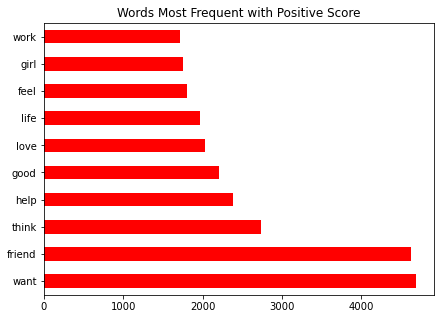

<Figure size 432x288 with 0 Axes>

In [48]:
plt.figure(figsize=(7,5))
plt.title('Words Most Frequent with Positive Score')
posi_eda_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='red');
#plt.savefig('posi_eda_words.png', dpi=300)
plt.show();
plt.tight_layout();

In [50]:
neg_df = second_df_sentiment[['neg', 'pos', 'alltext']].sort_values('neg', ascending=False).head(5000)

In [51]:
cvec_eda_neg = CountVectorizer(stop_words = 'english', max_features = 20_000)

neg_eda = neg_df['alltext']
neg_eda = cvec_eda_neg.fit_transform(neg_eda)
neg_eda_df = pd.DataFrame(neg_eda.todense(), columns = cvec_eda_neg.get_feature_names())

In [52]:
neg_eda_df.sum().sort_values(ascending = False).head(15)

want       4416
think      3339
friend     3038
life       2698
feel       2268
help       2096
work       2073
start      1978
women      1953
need       1801
tri        1692
good       1645
thought    1599
fuck       1528
look       1490
dtype: int64

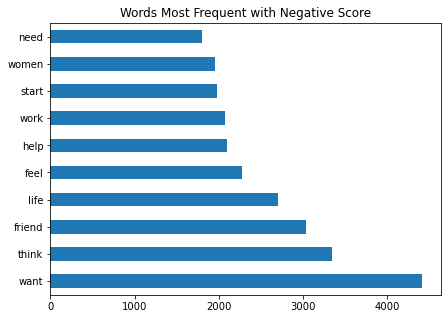

<Figure size 432x288 with 0 Axes>

In [53]:
plt.figure(figsize=(7,5))
neg_eda_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.title('Words Most Frequent with Negative Score')
#plt.savefig('neg_eda_words.png', dpi=200)
plt.show();
plt.tight_layout();

Based on the two charts, we don't see a huge degree of difference between the top 10 words from the positve score dataframe and the negative score dataframe.

#### Implementing N-grams

In this section of the EDA, I will explore the top bi-grams and tri-grams within the dataset

In [54]:
from nltk.util import ngrams

In [55]:
corpus=[]
men_say= mens_issues['all_text'].str.split()
men_say=mens_issues.values.tolist()
corpus=[word for i in men_say for word in i]

In [56]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [57]:
mens_issues['all_text'] = clean_strings(mens_issues['all_text'], stopwords = stop_words.stop_words)

In [58]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop_words=set(stopwords.words('english'))
    new_stopwords=['have', 'been', 'this', 'that', 'have', 'have been', 'they were', 'away from', 'they', 'rules still apply', 'even', 'though', 'even though', 'amazon gift card']
    new_stopwords_list = stop_words.union(new_stopwords)

    men_say= mens_issues['all_text'].str.split()
    men_say=mens_issues.values.tolist()
    corpus=[word for i in men_say for word in i if word not in new_stopwords_list]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.set(rc={'figure.figsize':(10,7)})
    sns.barplot(x=y,y=x)

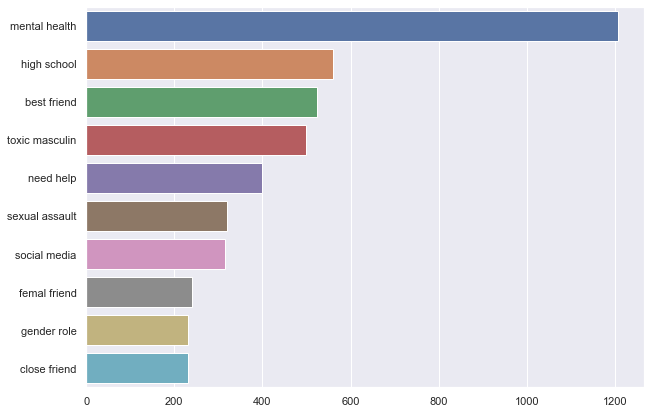

In [59]:
plot_top_ngrams_barchart(mens_issues['all_text'],2)

We can see that the majority of words appear to be referring to so something or someone. What really stood out here is "high school" being a top bi-gram. Furthermore, it appears that sexual assault, social media, and toxic masculinity are top words being represented in these sub-reddit posts.

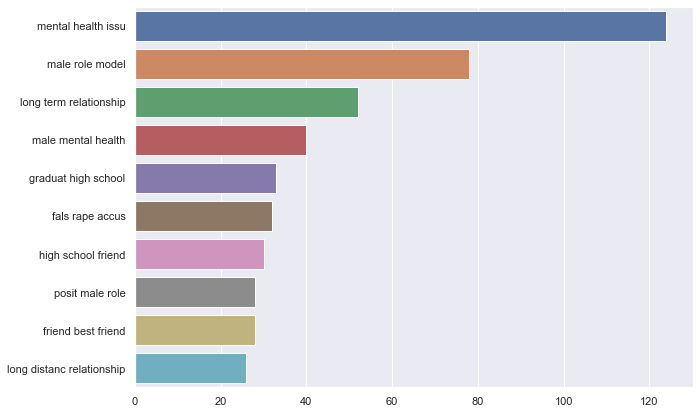

In [60]:
plot_top_ngrams_barchart(mens_issues['all_text'],3)

From this bar chart, we see more reoccurring themes of what most men are posting about, and that is male mental health, graduating high school, false rape accusations, and long-distance relationships, to name a few.

In [61]:
#mens_issues.to_csv('./men_df_eda.csv')

_____